This second practical work, on motion estimation, deals with parametric motion estimation. You have to reuse some of the functions you implemented during the first practical work.

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from cv2 import copyMakeBorder,BORDER_REPLICATE

# Parametric estimation
In this second practical work, we will work on parametric estimation, both using direct and indirect methods.
## I- Direct parametric estimation
## I-1 Theoretical questions

**Infinite signal**

Let $a: (n,m)\in \mathbb{Z}^2 \rightarrow \mathbb{R}$ be a bi-dimensional signal and $b(n,m)$ a signal of the same type.

Recall the expression of the 2D discrete time Fourier transform (DTFT).

<u>Answer:</u>

The 2D discrete-time Fourier transform (DTFT) of a bi-dimensional signal $a(n,m)$, where $(n,m) \in \mathbb{Z}^2$, into the frequency domain is given by the following expression:

$$
A(\omega_1, \omega_2) = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} a(n,m) e^{-j(\omega_1 n + \omega_2 m)}
$$


Let us suppose that
$\exists c,d \in \mathbb{Z}^2: \forall n,m \in \mathbb{Z}^2,b(n,m) = a(n+c,m+d)$ (that is, $b$ is a translation of $a$). Compute the DTFT of $b$ as a function of the one of $a$ and of the displacement $(c,d)$.

<u>End</u>

Show that the ratio between the DTFTs is:
$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$

<u>Answer:</u>

The DTFT of $b(n,m)$ is given by:
$$ \hat{b}(\nu_x,\nu_y) = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} b(n,m) e^{-i2\pi(\nu_x n + \nu_y m)} $$ 

We substitute $b(n,m)$ by $a(n+c,m+d)$, we get:

$$ \hat{b}(\nu_x,\nu_y) = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} a(n+c,m+d) e^{-i2\pi(\nu_x n + \nu_y m)} $$

We then conduct the change of variables by introducing $n' = n + c$ and $m' = m + d$, we get:
$$
\hat{b}(\nu_x,\nu_y) = \sum_{n'=-\infty}^{\infty} \sum_{m'=-\infty}^{\infty} a(n',m') e^{-i2\pi(\nu_x (n'-c) + \nu_y (m'-d))}
$$

By simplifying the expression, we get:
$$
\hat{b}(\nu_x,\nu_y) = e^{i2\pi(c\nu_x + d\nu_y)} \sum_{n'=-\infty}^{\infty} \sum_{m'=-\infty}^{\infty} a(n',m') e^{-i2\pi(\nu_x n' + \nu_y m')}
$$

Therefore, we have
$$
\hat{b}(\nu_x,\nu_y) = e^{i2\pi(c\nu_x + d\nu_y)} \hat{a}(\nu_x,\nu_y)
$$

This gives the ratio between the DTFTs:
$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$

<u>End</u>


**Finite signal**

Now, $a: (n,m) \in \{0,1,...,N-1\}^2 \rightarrow \mathbb{R}$ and $b(n,m)$ are both finite signals. In that case, we use the Discrete Fourier Transform (DFT) rather than the DTFT.

Recall the expression of the DFT.

<u>Answer:</u>

The DFT of a two-dimensional signal $a(n,m)$, where $(n,m) \in \{0,1,\ldots,N-1\}^2$, is given by:

$$
\hat{A}(u,v) = \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} a(n,m) e^{-i2\pi\left(\frac{un}{N} + \frac{vm}{N}\right)}
$$
<u>End</u>


Under which hypotheses is the ratio between $a$'s and $b$'s DFT a linear phase signal:
$$
\frac{\hat{A}(k_x,k_y)}{\hat{B}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)
$$

<u>Answer:</u>

This relationship holds under the assumption that $b(n,m)$ is a translated version of $a(n,m)$ by a displacement vector $(c, d)$ within a finite domain, and both signals are periodic with period $N$ in both dimensions. 

The inference process is similar to that of DTFT.
<u>End</u>


## I-2 Practical part
First, start to work on the 'ball.mat' image. We will apply a translation to this image and try to estimate the parameter of the translation.

Try by either adding or not some noise into the image.

In [2]:
im1 = loadmat('ball.mat')['im1']
im1 = im1.astype('float')

#im1 = loadmat('lena.mat')['im1']
#im1 = im1.astype('float')

N, M = np.shape(im1)

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x145958d00>)

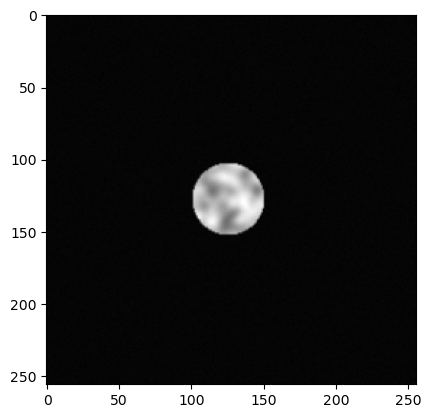

In [3]:
# Potentially add noise to the image
sigma = 1
im1 = im1 + np.random.normal(0, sigma, (N, M)) # Add Gaussian noise
plt.figure(),plt.imshow(im1,cmap='gray')

In the following, we apply a translation to the image. To do that, use the applyAffineMotion function which is already pre-implemented.

In [4]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp


def applyAffineMotion(x,b,B = np.zeros((2,2)),out = 100):
    N, M = np.shape(x)
    px, py = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1), np.arange(-(N-1)/2,(N-1)/2+1))
    
    mvfx = b[0] + B[0,0]*px + B[0,1]*py
    mvfy = b[1] + B[1,0]*px + B[1,1]*py
    
    mvf = np.zeros((np.shape(mvfx)[0],np.shape(mvfx)[1],2))
    mvf[:,:,1] = mvfx
    mvf[:,:,0] = mvfy
    
    y = fracMc(x,mvf,out)
    return y

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x145b90f40>)

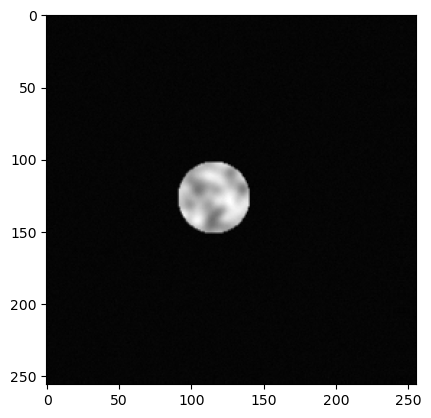

In [5]:
horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')

Compute the FFT of the two images. Using the indications given in the theroretical part, describe a method with which you can find the parameters of the translation from the two FFTs.

**Answer:**

According to 
$$
\frac{\hat{A}(k_x,k_y)}{\hat{B}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)
$$

the difference of phase between the two FFTs can derive the translation parameters, then we can use the median of the graident of phase difference or computes the least Square planar approximation of the phase difference to obtain the parameters of the translation.


In [6]:
IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

Compute the phase of the Fourier transform.

In [7]:
def angle2D(x):
    a = np.angle(x)
    
    b1 = np.unwrap(a,axis=0)
    b2 = np.unwrap(b1,axis=1)
    b3 = np.unwrap(a,axis=0)[:,::-1]
    b4 = np.unwrap(b3,axis=1)[:,::-1]
    
    y = (b2+b4)/2./(-2.*np.pi)
    return y

In [8]:
phi = angle2D(IM2/IM1)

Display phi. Is it a linear plane and why?

**Answer:**

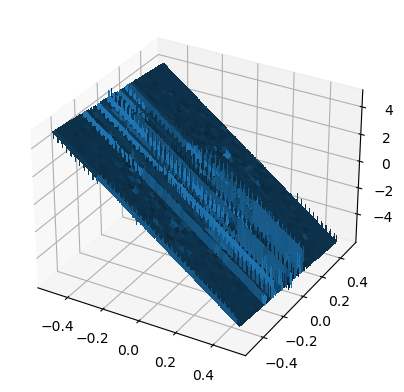

In [9]:
fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)

phi is a linear plane, that is because the phase difference is linearly dependent on the frequency.

Translation estimation: to estimate the parameters of the translation, we are now looking for the slope of the plane.

Method 1: estimate it using the median of the gradient. To do that, complete the gradient function.

In [11]:
def gradient(M,stepX=1.,stepY=1.):
# Computes the gradient of an image, over the rows and the column directions. StepY is the assumed gap between the rows and StepX is the assumed gap between the columns

    gy = np.zeros((np.shape(M)[0],np.shape(M)[1]))
    gx = np.zeros((np.shape(M)[0],np.shape(M)[1]))
    
    gy[0:-1,:] = (M[1:,:]-M[0:-1,:])/stepY
    gx[:,0:-1] = (M[:,1:]-M[:,0:-1])/stepX
    
    return gx,gy

In [12]:
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)

In [13]:
print(GX)
print(GY)

-9.979856095626772
-1.062538359965231


Method 2: the code below computes the least Square planar approximation of phi, enabling you how to estimate the parameters of the translation. Explain how it works.

**Answer:**

`phi = phi-phi[int(N/2+2), int(M/2+2)]` substracts a reference value (center of phi) from all elements in phi.

`t = medianFilter(phi,1)` applies a median filter to phi, this helps to remove noise.

To find the least square planar approximation of phi, we want to fit the best plane of phi, hence we need to find x which make the squared sum of the difference between Ax and b the smallest. Therefore, by approximately solving $x=A^{-1}b$, we can obtain the least square planar approximation of phi.


In [14]:
def medianFilter(x,N):
    z = copyMakeBorder(x, N, N, N, N, BORDER_REPLICATE)
    y = np.zeros(np.shape(x))
    
    for r in range(np.shape(x)[0]):
        for c in range(np.shape(x)[1]):
            tmp = z[r:r+2*N+1,c:c+2*N+1]
            y[r,c] = np.median(tmp)
    return y

In [15]:
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

In [16]:
print(bEst)

[-9.7761861  -0.99815178]


**Relaunch the above code**:
- with and without noise
- with the lena image, instead of the ball image.

Each time, are you able to correctly estimate the translation? Why? Comment your results.

**Answer:**

We can't correctly estimate the translation of lena image whether with or without noise. Because the lena image is much more complicated and content of image changes after translation, but the method proposed assumes the content of image does not change. Therefore, the phi we obtained through FFT is not in the shape of a fine plane.

#### without noise

Results for method 1
-10.0
-1.0
Results for method 2
[-9.99981832 -0.99999929]


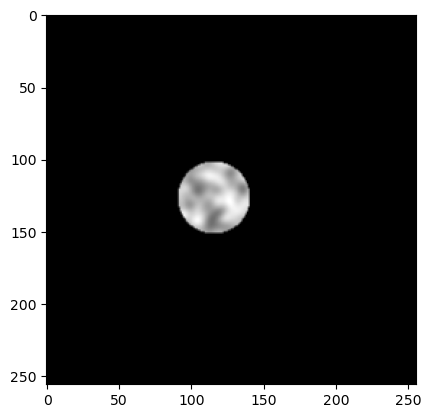

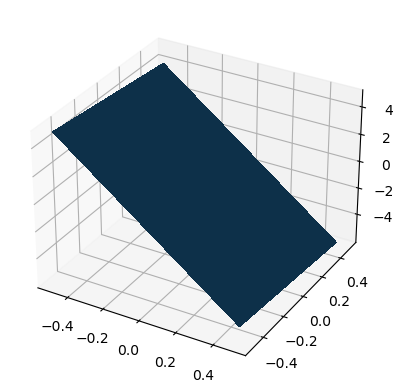

In [17]:
im1 = loadmat('ball.mat')['im1']
im1 = im1.astype('float')

N, M = np.shape(im1)

horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')

# compute fft and phase
IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)
phi = angle2D(IM2/IM1)

fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)

# method1: compute the gradient of the phase
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)
print('Results for method 1')
print(GX)
print(GY)

# method2: compute the least square planar approximation of the phase
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)
print('Results for method 2')
print(bEst)

#### lena image without noise

Results for method 1
-8.920841577295676
0.0
Results for method 2
[-7.90761829 -0.01702052]


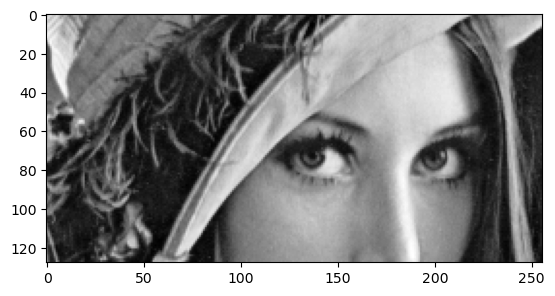

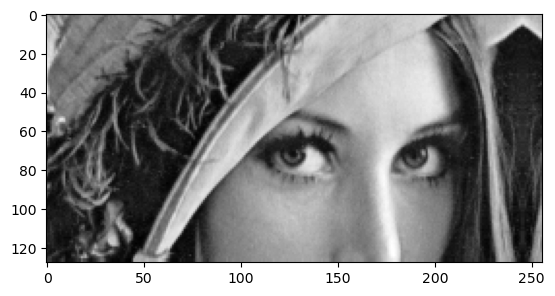

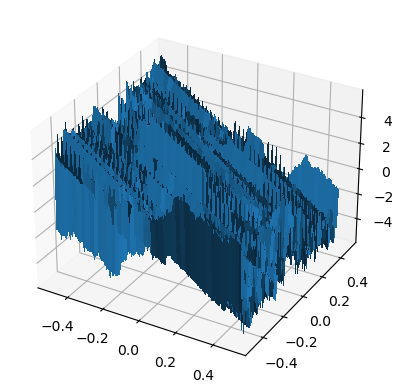

In [19]:
im1 = loadmat('lena.mat')['im1']
im1 = im1.astype('float')
plt.figure(),plt.imshow(im1,cmap='gray')

N, M = np.shape(im1)

horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')

# compute fft and phase
IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)
phi = angle2D(IM2/IM1)

fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)

# method1: compute the gradient of the phase
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)
print('Results for method 1')
print(GX)
print(GY)

# method2: compute the least square planar approximation of the phase
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)
print('Results for method 2')
print(bEst)

#### lena image with noise

Results for method 1
-9.139386316257571
3.271645063205966
Results for method 2
[-8.0166055  0.0177092]


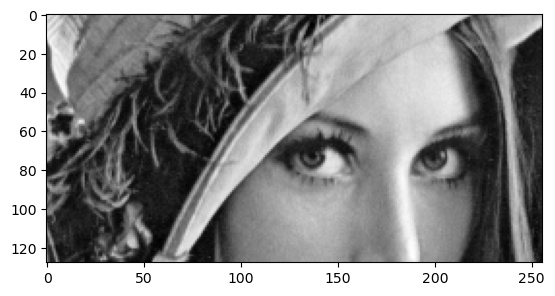

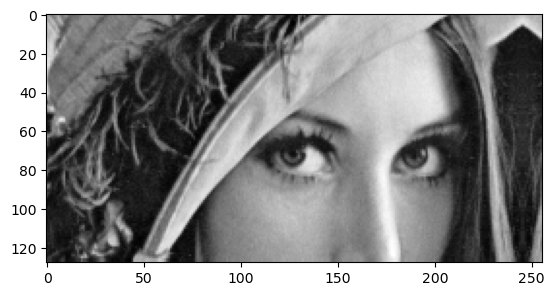

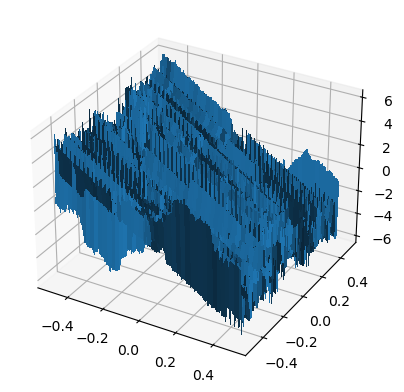

In [21]:
im1 = loadmat('lena.mat')['im1']
im1 = im1.astype('float')

# Potentially add noise to the image
sigma = 1
im1 = im1 + np.random.normal(0, sigma, (N, M)) # Add Gaussian noise
plt.figure(),plt.imshow(im1,cmap='gray')

N, M = np.shape(im1)

horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')

# compute fft and phase
IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)
phi = angle2D(IM2/IM1)

fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)

# method1: compute the gradient of the phase
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)
print('Results for method 1')
print(GX)
print(GY)

# method2: compute the least square planar approximation of the phase
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)
print('Results for method 2')
print(bEst)

# II-Indirect parametric estimation
In this last part, we will perform indirect parametric estimation. The movement vector field will be estimated by 1) block matching; 2) optic flow. **You have to reuse here the functions that you implemented during the first practical work**. Each time, you will then estimate the translation by taking the median of the estimated vector field.

Perform the experiment without and with noise (you can then take sigma = 2).

Finally, compare all the parametric estimation methods when the translation values are not integer.

**Answer:**

We can see that the indirect parametric estimation both have good results on the lena image with or without noise.

**Answer:**

When the translation values are not integer.

The direct parametric estimation by computing the gradient of the phase can still perform well on the ball image without noise. However, the indirect parametric estimation is not functional when the translation values are not integer.

In [22]:
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search # search is the searching radius
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    
    # Non-regularized search
    if lamb == 0.:
        search_range = range(-search, search+1)
        for r in range(0, cur.shape[0], brow) : # fill: for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, cur.shape[1], bcol) : # fill
                # current block selection
                B = cur[r:r+brow, c:c+bcol] # fill: Block

                # Initialization:
                #... # fill: ??
                costMin = np.inf # fill, initialize as infinity cost
                Rbest = B # fill, the best corresponding block in the reference image?
                drowBest = 0
                dcolBest = 0
                
                # Loop on candidate displacement vectors
                for dcol in search_range: # fill: dcol = candidate displacement vector over the columns, use the radius as well
                    for drow in search_range:# fill: rcol = candidate displacement vector over the rows

                        row_start = r + drow + extension # fill
                        col_start = c + dcol + extension

                        curr_ref_block = ref_extended[row_start:row_start+brow, col_start:col_start+bcol] # fill: the block that we're examining?
                        curr_cost = np.sum((B - curr_ref_block)**2)
                        if curr_cost < costMin: # Save the results if they are better than the previous ones
                            costMin = curr_cost
                            Rbest = curr_ref_block
                            drowBest = drow
                            dcolBest = dcol
                            
                mvf[r:r+brow,c:c+bcol,0] = drowBest # fill: Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1] = dcolBest # fill: Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]= Rbest
                
    else: # Regularized search
        search_range = range(-search, search+1)
        for r in range(0, cur.shape[0], brow) : #fill: for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, cur.shape[1], bcol) : # fill
                # current block selection
                B = cur[r:r+brow, c:c+bcol] # Block

                # Initializations
                ... # fill: ??
                costMin = np.inf
                Rbest = B
                drowBest = 0
                dcolBest = 0

                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r,c,brow,bcol,mvf,ref,cur)

                # Loop on candidate vectors
                for dcol in search_range: # dcol = candidate displacement vector over the columns
                    for drow in search_range: # rcol = candidate displacement vector over the rows
                        row_start = r + drow + extension # fill
                        col_start = c + dcol + extension
                        curr_ref_block = ref_extended[row_start:row_start+brow, col_start:col_start+bcol] # fill: the block that we're examining?
                        curr_cost = np.sum((B - curr_ref_block)**2) + lamb * np.linalg.norm(np.array([drow, dcol]).reshape(pV.shape) - pV) # here, encore the REGULARIZED cost function
                        if curr_cost < costMin: # Save the results if they are better than the previous ones
                            costMin = curr_cost
                            Rbest = curr_ref_block
                            drowBest = drow
                            dcolBest = dcol


                mvf[r:r+brow,c:c+bcol,0] = drowBest # fill: Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1] = dcolBest # fill: Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]= Rbest
                
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

In [23]:
def displayMVF(I,mvf,subsamp):
    
    row,col = np.shape(I)
    
    # Subsample dense MVF 
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]
    
    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)
    
    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow)

    
    return

### without noise

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1476e66a0>)

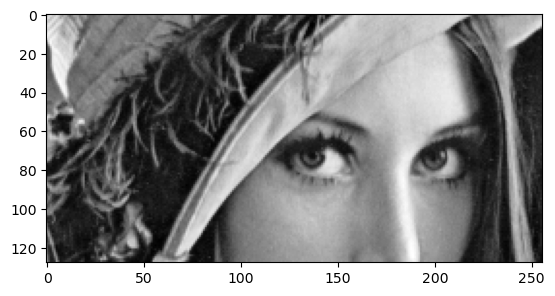

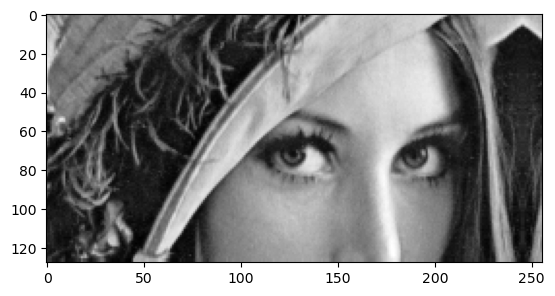

In [29]:
im1 = loadmat('lena.mat')['im1']
im1 = im1.astype('float')
plt.figure(),plt.imshow(im1,cmap='gray')

N, M = np.shape(im1)

horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')

-10.0
-1.0


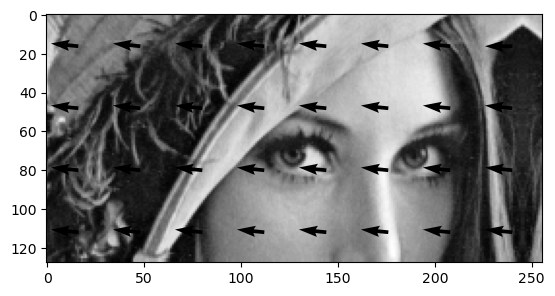

In [30]:
lamb = 0
mvf,prediction = me_ssd(im2,im1,32,32,10,lamb)
displayMVF(im2,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

Estimation with optic flow

In [27]:
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337
    
    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)
    
    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """
    
    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)
    
    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()
    
    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)
    
    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])
    
    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg= convolve2d(u, kernel_1, 'same')
        vAvg= convolve2d(v, kernel_1, 'same')
        
        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg - fx * (uAvg*fx + vAvg*fy + ft)/(alpha**2 + fx**2 + fy**2)
        v = vAvg - fy * (uAvg*fx + vAvg*fy + ft)/(alpha**2 + fx**2 + fy**2)
        
    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft

-5.130837828048705
-0.49740836543330075


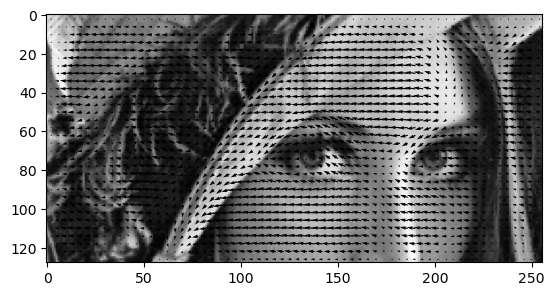

In [31]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

### with noise

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x147306c40>)

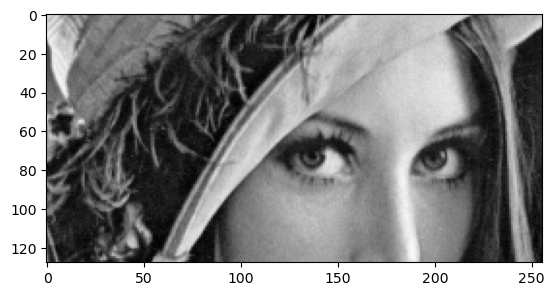

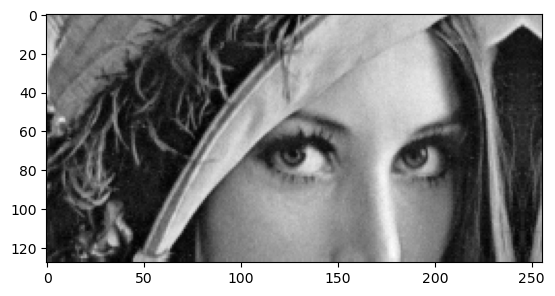

In [35]:
im1 = loadmat('lena.mat')['im1']
im1 = im1.astype('float')

# Potentially add noise to the image
sigma = 2
im1 = im1 + np.random.normal(0, sigma, (N, M)) # Add Gaussian noise
plt.figure(),plt.imshow(im1,cmap='gray')

N, M = np.shape(im1)

horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')

-10.0
-1.0


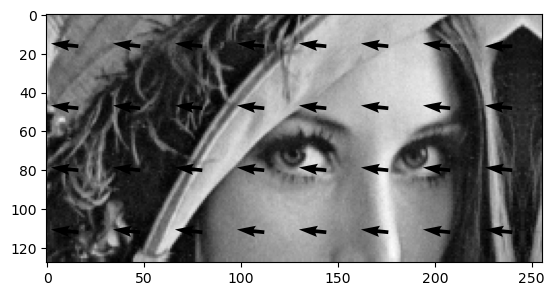

In [36]:
# block matching

lamb = 0
mvf,prediction = me_ssd(im2,im1,32,32,10,lamb)
displayMVF(im2,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

-5.120124564597016
-0.49547811044085743


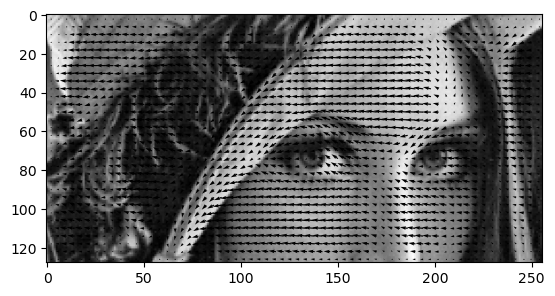

In [37]:
# estimate the optical flow

alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

## Translation value is not integer

### Direct methods on ball without noise

Results for method 1
-9.810493910914552
-1.696848839225595
5.781595675541641
Results for method 2
[-9.90938215  6.85469565]
-1.4456341551709164


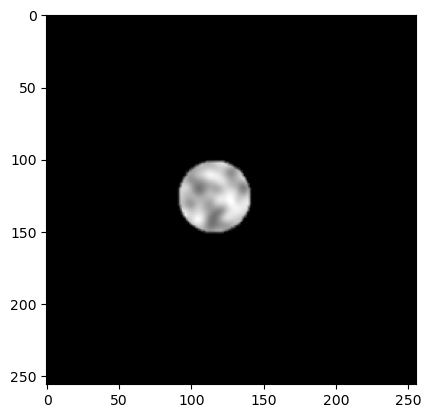

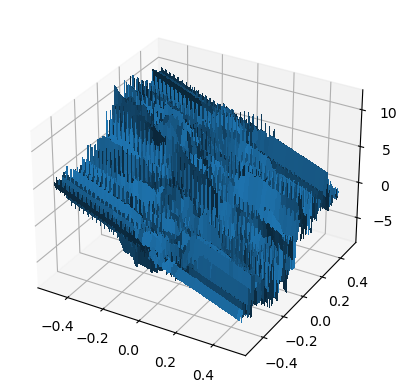

In [42]:
im1 = loadmat('ball.mat')['im1']
im1 = im1.astype('float')
N, M = np.shape(im1)

horiz_displacement = 9.5
vert_displacement  = 1.5
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')

# compute fft and phase
IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)
phi = angle2D(IM2/IM1)

fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)

# method1: compute the gradient of the phase
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)
print('Results for method 1')
print(GX)
print(GY)
print(GX/GY)

# method2: compute the least square planar approximation of the phase
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)
print('Results for method 2')
print(bEst)
print(bEst[0]/bEst[1])

### Direct methods on ball with noise

Results for method 1
-8.568246686256032
-4.924846951654862
1.7397995857265987
Results for method 2
[-4.21727706 -2.12788549]
1.9819097729169042


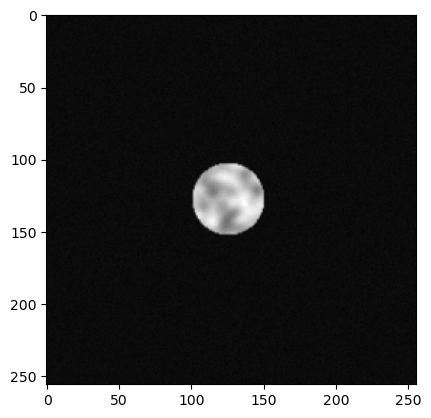

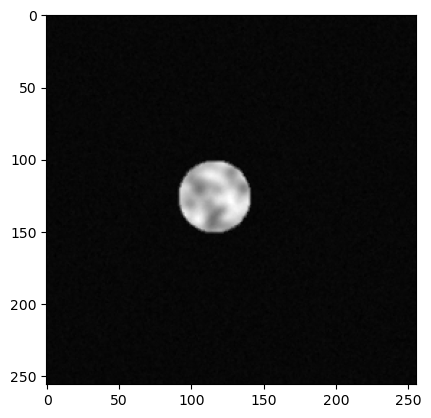

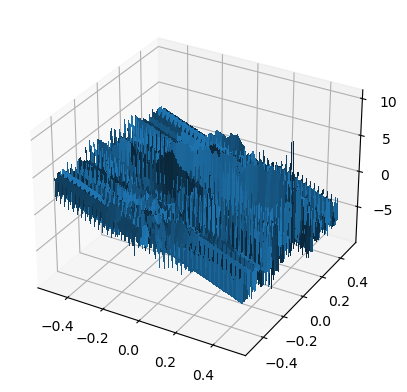

In [40]:
im1 = loadmat('ball.mat')['im1']
im1 = im1.astype('float')
N, M = np.shape(im1)

sigma = 2
im1 = im1 + np.random.normal(0, sigma, (N, M)) # Add Gaussian noise
plt.figure(),plt.imshow(im1,cmap='gray')

horiz_displacement = 9.5
vert_displacement  = 1.5
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')

# compute fft and phase
IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)
phi = angle2D(IM2/IM1)

fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)

# method1: compute the gradient of the phase
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)
print('Results for method 1')
print(GX)
print(GY)
print(GX/GY)

# method2: compute the least square planar approximation of the phase
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)
print('Results for method 2')
print(bEst)
print(bEst[0]/bEst[1])

In [41]:
9.5/1.5

6.333333333333333

### Indirect methods on ball without noise

block matching
10.0
10.0
1.0
optical flow
9.899609072089742
9.72500356906912
1.0179542867805174


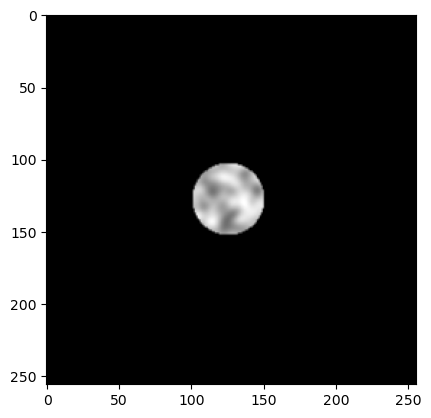

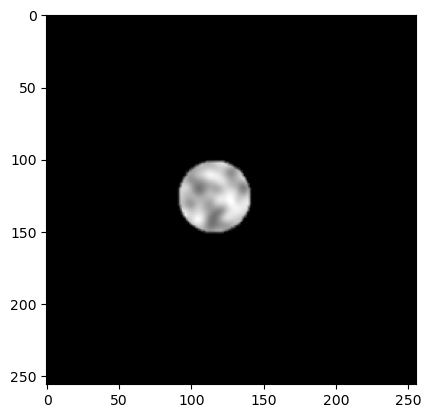

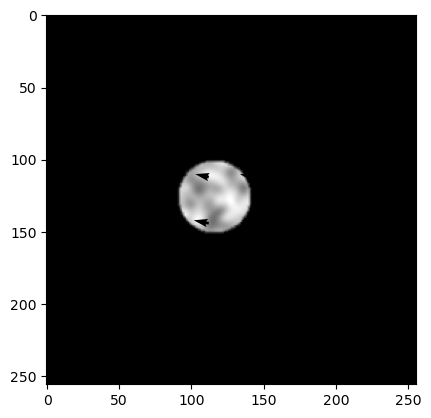

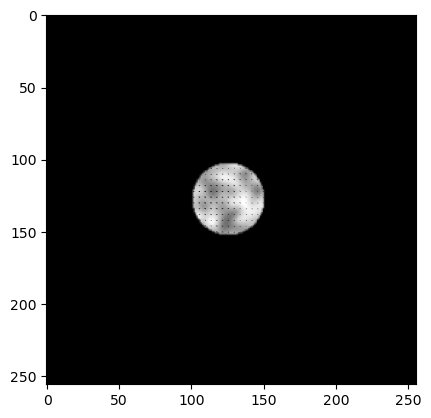

In [49]:
im1 = loadmat('ball.mat')['im1']
im1 = im1.astype('float')
plt.figure(),plt.imshow(im1,cmap='gray')

N, M = np.shape(im1)

horiz_displacement = 9.5
vert_displacement  = 1.5
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')

# block matching
lamb = 0
mvf,prediction = me_ssd(im2,im1,32,32,10,lamb)
displayMVF(im2,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print('block matching')
print(bx)
print(by)
print(bx/by)

# estimate the optical flow

alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print('optical flow')
print(bx)
print(by)
print(bx/by)

### Indirect methods on lena without noise

block matching
-9.0
-2.0
4.5
optical flow
-4.984869759320064
-0.6187578080609568
8.05625350400262


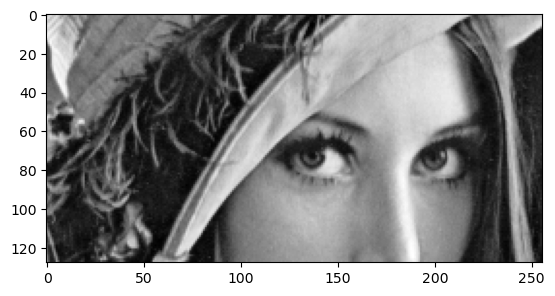

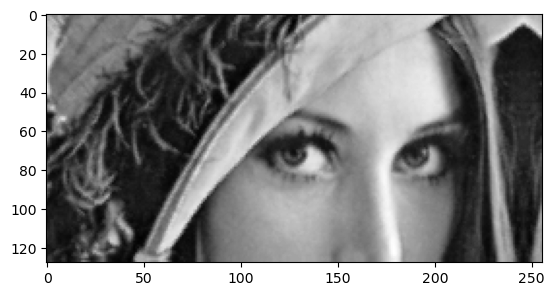

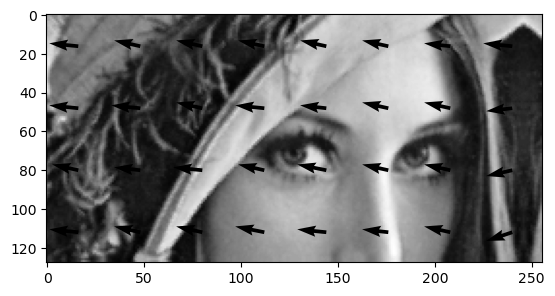

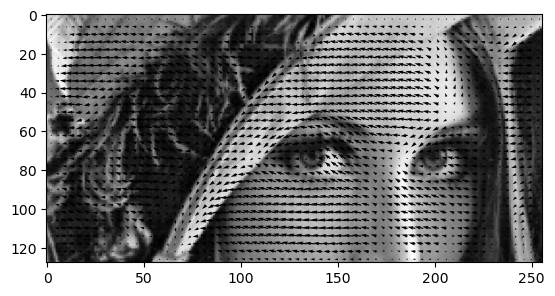

In [45]:
im1 = loadmat('lena.mat')['im1']
im1 = im1.astype('float')
plt.figure(),plt.imshow(im1,cmap='gray')

N, M = np.shape(im1)

horiz_displacement = 9.5
vert_displacement  = 1.5
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')

# block matching
lamb = 0
mvf,prediction = me_ssd(im2,im1,32,32,10,lamb)
displayMVF(im2,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print('block matching')
print(bx)
print(by)
print(bx/by)

# estimate the optical flow

alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print('optical flow')
print(bx)
print(by)
print(bx/by)

### Indirect methods on lena with noise

block matching
-9.0
-1.0
9.0
optical flow
-5.043151240045504
-0.5086131976224942
9.915494256971012


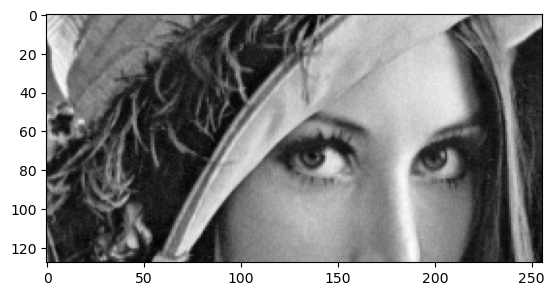

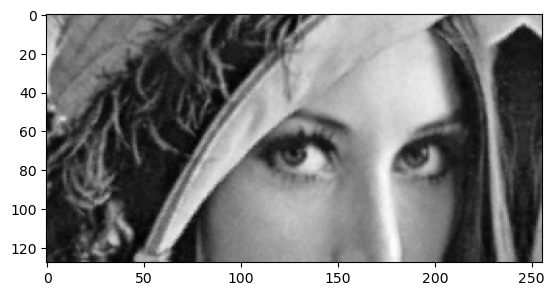

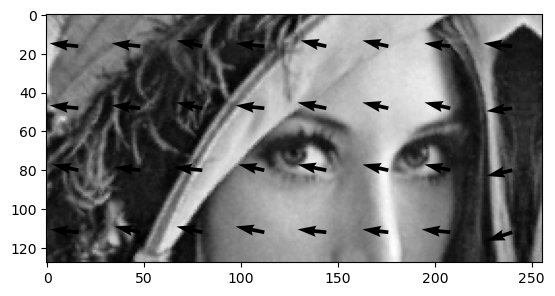

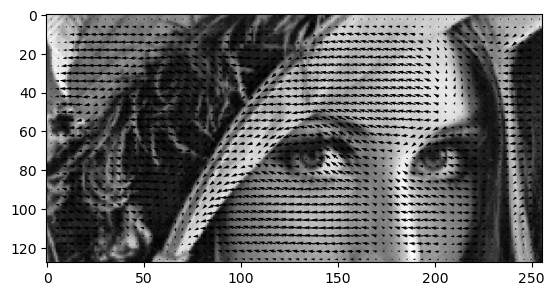

In [46]:
im1 = loadmat('lena.mat')['im1']
im1 = im1.astype('float')

sigma = 2
im1 = im1 + np.random.normal(0, sigma, (N, M)) # Add Gaussian noise
plt.figure(),plt.imshow(im1,cmap='gray')

N, M = np.shape(im1)

horiz_displacement = 9.5
vert_displacement  = 1.5
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')

# block matching
lamb = 0
mvf,prediction = me_ssd(im2,im1,32,32,10,lamb)
displayMVF(im2,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print('block matching')
print(bx)
print(by)
print(bx/by)

# estimate the optical flow

alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print('optical flow')
print(bx)
print(by)
print(bx/by)